# In this notebook the predictor will be used to estimate the new states and rewards for the dyna (hallucinated) iterations, of the Q-learning agent.

In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

from sklearn.externals import joblib

Populating the interactive namespace from numpy and matplotlib


## First, let's try to instantiate the best predictor that was found

In [2]:
best_params_df = pd.read_pickle('../../data/best_params_final_df.pkl')
best_params_df

,GOOD_DATA_RATIO,SAMPLES_GOOD_DATA_RATIO,ahead_days,base_days,model,mre,r2,step_days,train_days,train_val_time,x_filename,y_filename
ahead_days,,,,,,,,,,,,
1.0,0.99,0.9,1.0,112.0,linear,0.015856,0.986599,7.0,504.0,-1.0,x_base112_ahead1.pkl,y_base112_ahead1.pkl
7.0,0.99,0.9,7.0,112.0,linear,0.042367,0.923348,7.0,756.0,-1.0,x_base112_ahead7.pkl,y_base112_ahead7.pkl
14.0,0.99,0.9,14.0,112.0,linear,0.060167,0.865259,7.0,756.0,-1.0,x_base112_ahead14.pkl,y_base112_ahead14.pkl
28.0,0.99,0.9,28.0,112.0,linear,0.091966,0.758046,7.0,756.0,-1.0,x_base112_ahead28.pkl,y_base112_ahead28.pkl
56.0,0.99,0.9,56.0,112.0,linear,0.127913,0.590426,7.0,756.0,-1.0,x_base112_ahead56.pkl,y_base112_ahead56.pkl


Mean metrics: 
        train      test
r2   0.983486  0.976241
mre  0.008762  0.013906
----------------------------------------------------------------------


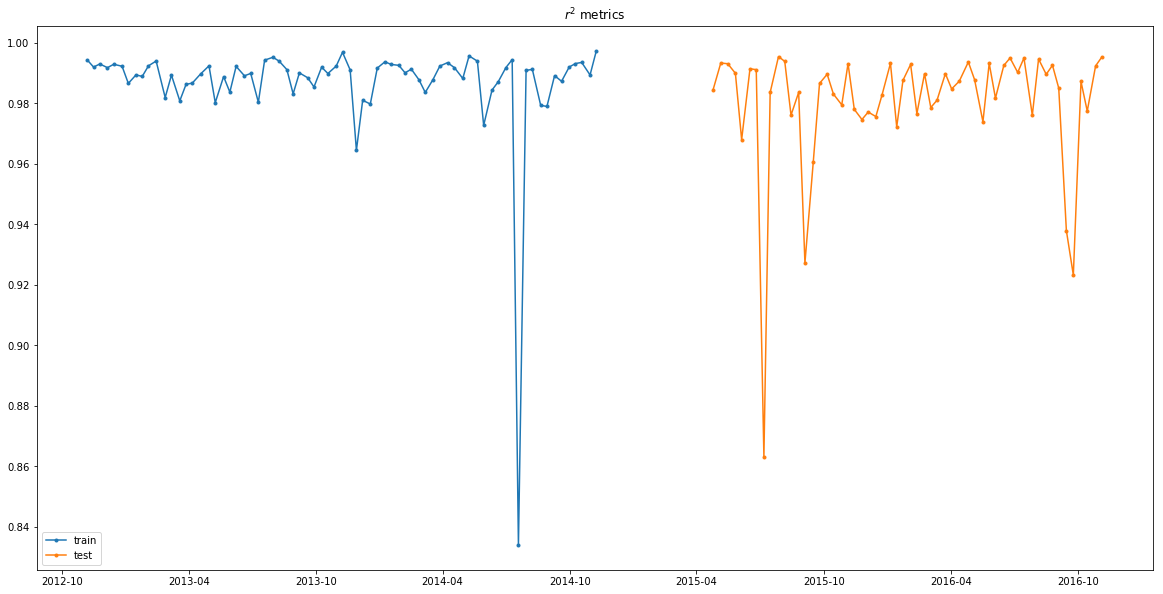

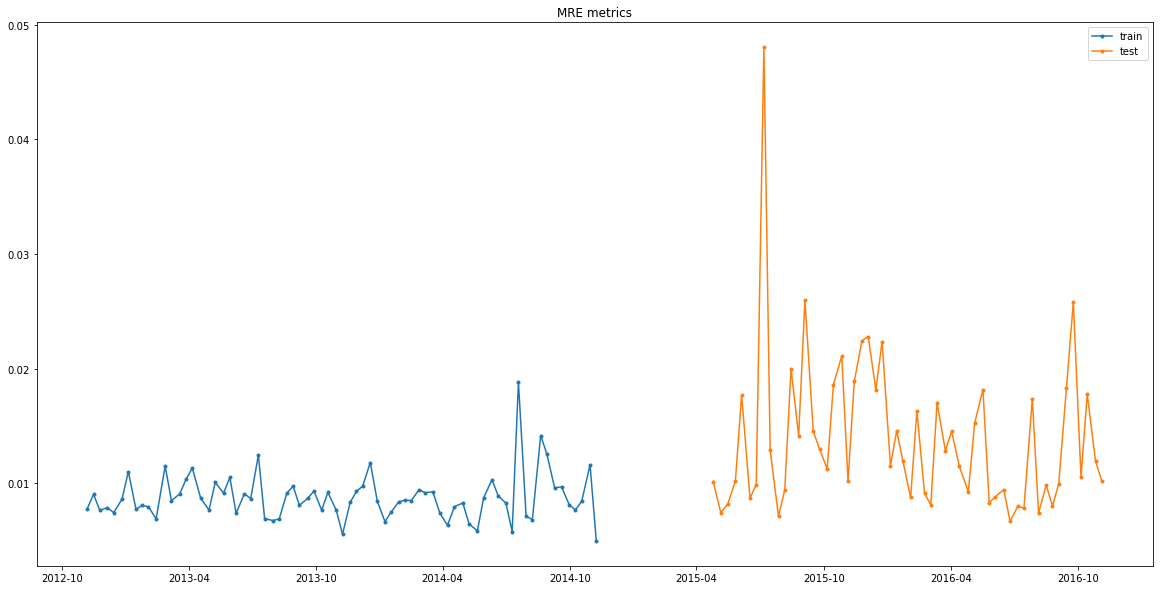

In [3]:
import predictor.feature_extraction as fe
from predictor.linear_predictor import LinearPredictor
import utils.misc as misc
import predictor.evaluation as ev

ahead_days = 1

# Get some parameters
train_days = int(best_params_df.loc[ahead_days, 'train_days'])
GOOD_DATA_RATIO, \
train_val_time, \
base_days, \
step_days, \
ahead_days, \
SAMPLES_GOOD_DATA_RATIO, \
x_filename, \
y_filename = misc.unpack_params(best_params_df.loc[ahead_days,:])

pid = 'base{}_ahead{}'.format(base_days, ahead_days)

# Get the datasets
x_train = pd.read_pickle('../../data/x_{}.pkl'.format(pid))
y_train = pd.read_pickle('../../data/y_{}.pkl'.format(pid))
x_test = pd.read_pickle('../../data/x_{}_test.pkl'.format(pid)).sort_index()
y_test = pd.DataFrame(pd.read_pickle('../../data/y_{}_test.pkl'.format(pid))).sort_index()

# Let's cut the training set to use only the required number of samples
end_date = x_train.index.levels[0][-1]
start_date = fe.add_market_days(end_date, -train_days)
x_sub_df = x_train.loc[(slice(start_date,None),slice(None)),:]
y_sub_df = pd.DataFrame(y_train.loc[(slice(start_date,None),slice(None))])

# Create the estimator and train
estimator = LinearPredictor()
estimator.fit(x_sub_df, y_sub_df)

# Get the training and test predictions
y_train_pred = estimator.predict(x_sub_df)
y_test_pred = estimator.predict(x_test)

# Get the training and test metrics for each symbol
metrics_train = ev.get_metrics_df(y_sub_df, y_train_pred)
metrics_test = ev.get_metrics_df(y_test, y_test_pred)

# Show the mean metrics
metrics_df = pd.DataFrame(columns=['train', 'test'])
metrics_df['train'] = metrics_train.mean()
metrics_df['test'] = metrics_test.mean()
print('Mean metrics: \n{}\n{}'.format(metrics_df,'-'*70))

# Plot the metrics in time
metrics_train_time = ev.get_metrics_in_time(y_sub_df, y_train_pred, base_days + ahead_days)
metrics_test_time = ev.get_metrics_in_time(y_test, y_test_pred, base_days + ahead_days)
plt.plot(metrics_train_time[2], metrics_train_time[0], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[0], label='test', marker='.')
plt.title('$r^2$ metrics')
plt.legend()
plt.figure()
plt.plot(metrics_train_time[2], metrics_train_time[1], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[1], label='test', marker='.')
plt.title('MRE metrics')
plt.legend()

### Let's see the range of the test set (to check that no data from the recommender test set is in the training set for the predictor)

In [4]:
print('The first training day for the predictor is: {}.'.format(start_date))

The first training day for the predictor is: 2012-07-16 00:00:00.


In [5]:
print('The last training day for the predictor is: {}.'.format(fe.add_market_days(end_date, base_days)))

The last training day for the predictor is: 2014-12-26 00:00:00.


In [6]:
print('The testing data for the recommender')
total_data_test_df = pd.read_pickle('../../data/data_test_df.pkl').stack(level='feature')
total_data_test_df.head()

The testing data for the recommender


A          AAL        AAP         AAPL  \
date       feature                                                    
2015-01-02 Close         40.56        53.91     158.56       109.33   
           High          41.31        54.60     162.50       111.44   
           Low           40.37        53.07     157.47       107.35   
           Open          41.18        54.28     160.85       111.39   
           Volume   1530798.00  10756705.00  509983.00  53204626.00   

                          ABBV         ABC         ABT         ACN  \
date       feature                                                   
2015-01-02 Close         65.89       90.46       44.90       88.84   
           High          66.40       91.32       45.45       90.09   
           Low           65.49       89.82       44.64       88.43   
           Open          65.62       90.61       45.25       89.67   
           Volume   5087291.00  1124780.00  3217165.00  2021565.00   

                          ADBE         ADI     ...            XLNX  \
date       feature                             ...                   
2015-01-02 Close         72.34       55.54     ...           43.60   
           High          73.20       56.25     ...           43.93   
           Low           71.89       54.97     ...           43.11   
           Open          72.70       55.68     ...           43.51   
           Volume   2356405.00  1329619.00     ...      2402443.00   

                            XOM        XRAY         XRX        XYL  \
date       feature                                                   
2015-01-02 Close          92.83       51.93       13.75      38.08   
           High           93.05       53.12       14.02      38.59   
           Low            91.81       51.88       13.66      37.50   
           Open           92.25       52.13       13.88      38.40   
           Volume   10220410.00  1829006.00  3912022.00  606118.00   

                           YHOO         YUM        ZBH        ZION         ZTS  
date       feature                                                              
2015-01-02 Close          50.17       72.35     112.59       28.29       43.31  
           High           50.78       73.51     114.61       28.72       43.70  
           Low            49.47       72.00     111.78       28.06       43.06  
           Open           50.66       73.44     114.21       28.67       43.46  
           Volume   11924473.00  1641557.00  909491.00  2299118.00  1784851.00  

[5 rows x 499 columns]

In [7]:
print('The first TEST day for the recommender is: {}'.format(total_data_test_df.index[-0]))

The first TEST day for the recommender is: (Timestamp('2015-01-02 00:00:00'), 'Close')


### Good!

### The predictor will be used as it is, without retraining, for simplicity and computational performance

In [8]:
joblib.dump(estimator, '../../data/best_predictor.pkl')

['../../data/best_predictor.pkl']

Let's test the saved predictor... just in case.

Mean metrics: 
        train      test
r2   0.983486  0.976241
mre  0.008762  0.013906
----------------------------------------------------------------------


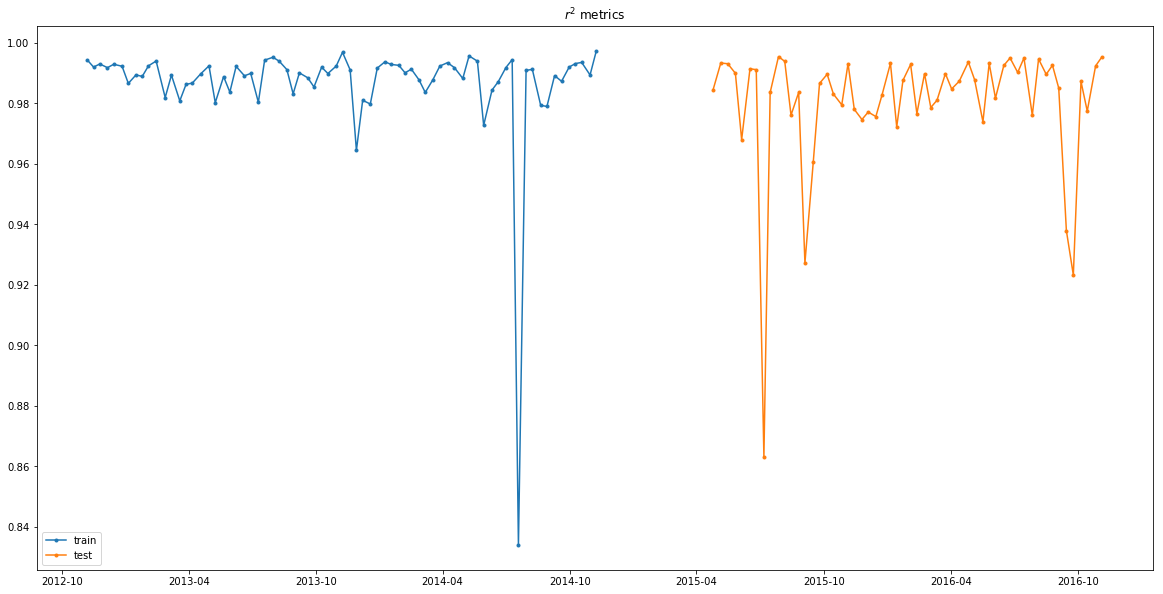

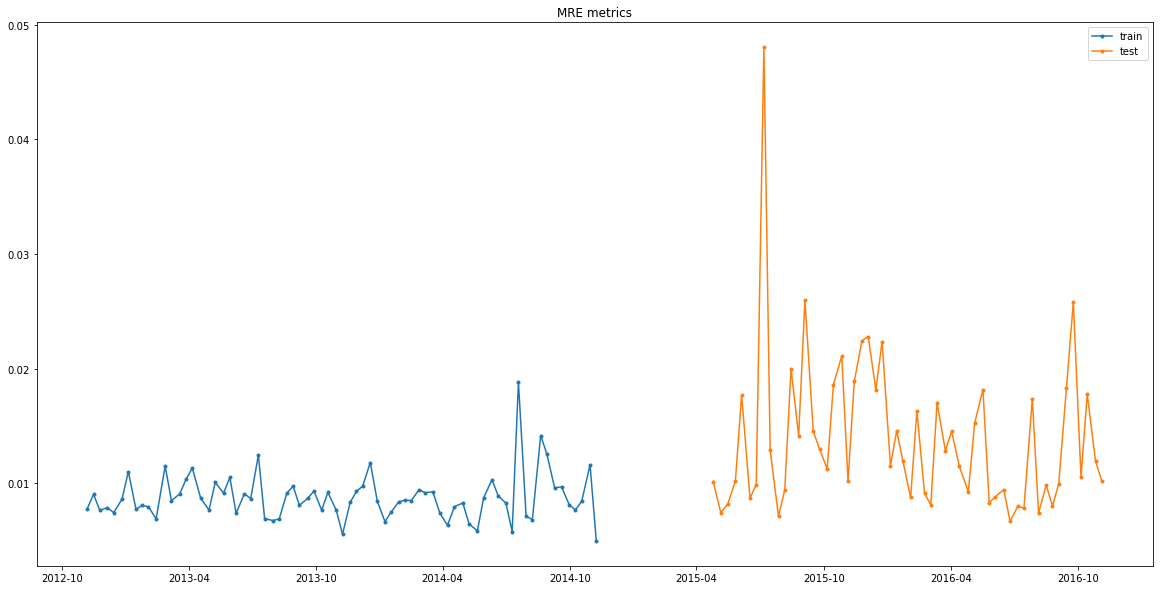

In [9]:
estimator_reloaded = joblib.load('../../data/best_predictor.pkl')

# Get the training and test predictions
y_train_pred = estimator_reloaded.predict(x_sub_df)
y_test_pred = estimator_reloaded.predict(x_test)

# Get the training and test metrics for each symbol
metrics_train = ev.get_metrics_df(y_sub_df, y_train_pred)
metrics_test = ev.get_metrics_df(y_test, y_test_pred)

# Show the mean metrics
metrics_df = pd.DataFrame(columns=['train', 'test'])
metrics_df['train'] = metrics_train.mean()
metrics_df['test'] = metrics_test.mean()
print('Mean metrics: \n{}\n{}'.format(metrics_df,'-'*70))

# Plot the metrics in time
metrics_train_time = ev.get_metrics_in_time(y_sub_df, y_train_pred, base_days + ahead_days)
metrics_test_time = ev.get_metrics_in_time(y_test, y_test_pred, base_days + ahead_days)
plt.plot(metrics_train_time[2], metrics_train_time[0], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[0], label='test', marker='.')
plt.title('$r^2$ metrics')
plt.legend()
plt.figure()
plt.plot(metrics_train_time[2], metrics_train_time[1], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[1], label='test', marker='.')
plt.title('MRE metrics')
plt.legend()

Looks good to me.

## Let's assume that the data comes as real values for one ticker

In [10]:
# Get the data
SYMBOL = 'SPY'
total_data_train_df = pd.read_pickle('../../data/data_train_val_df.pkl').stack(level='feature')
data_train_df = total_data_train_df[SYMBOL].unstack()[['Close', 'Volume']]

In [11]:
data_train_df.head()

feature,Close,Volume
date,,
1993-01-29,43.94,1003200.0
1993-02-01,44.25,480500.0
1993-02-02,44.34,201300.0
1993-02-03,44.81,529400.0
1993-02-04,45.00,531500.0


In [12]:
def generate_samples(data_df):
    start_date = data_df.index[0]
    close_sample = pd.DataFrame(data_df['Close'].values, columns=[start_date]).T
    close_sample = close_sample / close_sample.iloc[0,0]
    volume_sample = pd.DataFrame(data_df['Volume'].values, columns=[start_date]).T
    volume_sample = volume_sample / volume_sample.iloc[0,0]
    return close_sample, volume_sample

In [13]:
data_df = data_train_df[:112]

In [14]:
start_date = data_df.index[0]
close_sample = pd.DataFrame(data_df['Close'].values, columns=[start_date]).T
close_sample = close_sample / close_sample.iloc[0,0]
volume_sample = pd.DataFrame(data_df['Volume'].values, columns=[start_date]).T
volume_sample = volume_sample / volume_sample.iloc[0,0]

In [15]:
close_sample

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
1993-01-29,1.0,1.007055,1.009103,1.0198,1.024124,1.023441,1.023441,1.016386,1.017751,1.022758,...,1.019117,1.030496,1.025489,1.025489,1.022758,1.017069,1.006372,1.009103,1.020482,1.023441


In [16]:
close_sample, volume_sample = generate_samples(data_df)

In [17]:
close_sample

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
1993-01-29,1.0,1.007055,1.009103,1.0198,1.024124,1.023441,1.023441,1.016386,1.017751,1.022758,...,1.019117,1.030496,1.025489,1.025489,1.022758,1.017069,1.006372,1.009103,1.020482,1.023441


In [18]:
volume_sample

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
1993-01-29,1.0,0.478967,0.200658,0.527711,0.529805,0.49053,0.594199,0.121711,0.378389,0.019438,...,0.044657,0.438497,0.206838,0.436204,0.603768,0.28449,0.245614,0.342604,0.247408,0.376994


### Now, let's predict one step

In [19]:
history_df = data_train_df[:112]

In [20]:
estimator_close = joblib.load('../../data/best_predictor.pkl')
estimator_volume = joblib.load('../../data/best_volume_predictor.pkl')

In [21]:
h_history_df = history_df.copy()

In [22]:
def predict_one_step(h_history_df):
    close_sample, volume_sample = generate_samples(h_history_df)
    estimated_close = estimator_close.predict(close_sample).iloc[0,0] * h_history_df['Close'].iloc[0]
    estimated_volume = estimator_volume.predict(volume_sample).iloc[0,0] * h_history_df['Volume'].iloc[0]
    predicted_date = fe.add_market_days(h_history_df.index[-1], 1)
    h_history_df = h_history_df.drop(h_history_df.index[0])
    h_history_df.loc[predicted_date,:] = {'Close': estimated_close,'Volume': estimated_volume}
    return h_history_df

In [23]:
close_sample, volume_sample = generate_samples(h_history_df)
estimated_close = estimator_close.predict(close_sample).iloc[0,0] * h_history_df['Close'].iloc[0]
estimated_volume = estimator_volume.predict(volume_sample).iloc[0,0] * h_history_df['Volume'].iloc[0]

In [24]:
estimator_close.predict(close_sample).iloc[0,0]

1.0263297800006368

In [25]:
predicted_date = fe.add_market_days(h_history_df.index[-1], 1)
predicted_date

Timestamp('1993-07-12 00:00:00')

In [26]:
history_df

feature,Close,Volume
date,,
1993-01-29,43.94,1003200.0
1993-02-01,44.25,480500.0
1993-02-02,44.34,201300.0
1993-02-03,44.81,529400.0
1993-02-04,45.00,531500.0
1993-02-05,44.97,492100.0
1993-02-08,44.97,596100.0
1993-02-09,44.66,122100.0
1993-02-10,44.72,379600.0


In [27]:
h_history_df = h_history_df.drop(h_history_df.index[0])
h_history_df.loc[predicted_date,:] = {'Close': estimated_close,'Volume': estimated_volume}
h_history_df

feature,Close,Volume
date,,
1993-02-01,44.250000,480500.000000
1993-02-02,44.340000,201300.000000
1993-02-03,44.810000,529400.000000
1993-02-04,45.000000,531500.000000
1993-02-05,44.970000,492100.000000
1993-02-08,44.970000,596100.000000
1993-02-09,44.660000,122100.000000
1993-02-10,44.720000,379600.000000
1993-02-11,44.940000,19500.000000


In [28]:
h_history_df = history_df.copy()

for i in range(20):
    h_history_df = predict_one_step(h_history_df.copy())

### Just for fun, let's see some predictions...

In [29]:
h_history_df = history_df.copy()
predicted_df = pd.DataFrame()

for i in range(20):
    h_history_df = predict_one_step(h_history_df.copy())
    predicted_df = predicted_df.append(h_history_df.iloc[-1])


In [30]:
predicted_df

,Close,Volume
1993-07-12,45.096931,317005.444336
1993-07-13,45.272855,234663.131714
1993-07-14,45.352824,214566.215515
1993-07-15,45.394431,221401.904297
1993-07-16,45.528650,214040.344238
1993-07-19,45.531005,225595.892334
1993-07-20,45.584072,202098.783875
1993-07-21,45.672890,176303.114319
1993-07-22,45.680850,190819.433594
1993-07-23,45.593667,159563.713074


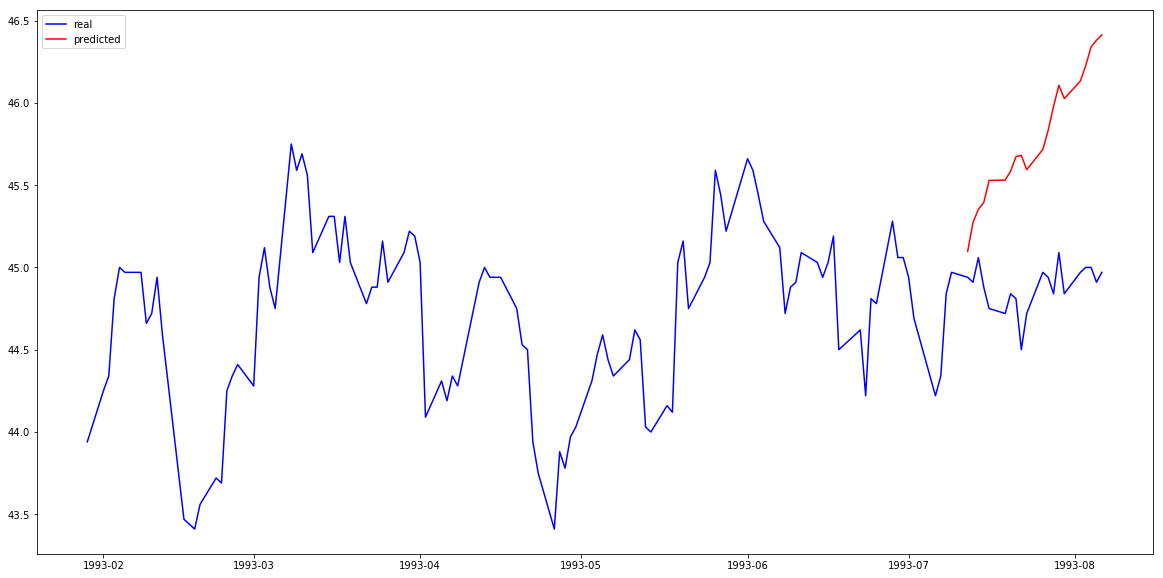

In [31]:
real_df = history_df.append(data_train_df[112:132])
plt.plot(real_df.index, real_df['Close'], 'b', label='real')
plt.plot(predicted_df.index, predicted_df['Close'], 'r', label='predicted')
plt.legend()
plt.show()

## Now that a one-step predictor is implemented, the new state and reward should be calculated. 

### One approach, that seems relatively clean, is to create a new, temporary, environment with the real and predicted data, to use with the "hallucinations".

In [132]:
h_history_df = history_df.copy()
h_history_df.head()

feature,Close,Volume
date,,
1993-01-29,43.94,1003200.0
1993-02-01,44.25,480500.0
1993-02-02,44.34,201300.0
1993-02-03,44.81,529400.0
1993-02-04,45.00,531500.0


In [133]:
stacked_h_history_df = pd.DataFrame(h_history_df.stack(), columns=[SYMBOL])
stacked_h_history_df

SPY
date       feature            
1993-01-29 Close         43.94
           Volume   1003200.00
1993-02-01 Close         44.25
           Volume    480500.00
1993-02-02 Close         44.34
           Volume    201300.00
1993-02-03 Close         44.81
           Volume    529400.00
1993-02-04 Close         45.00
           Volume    531500.00
1993-02-05 Close         44.97
           Volume    492100.00
1993-02-08 Close         44.97
           Volume    596100.00
1993-02-09 Close         44.66
           Volume    122100.00
1993-02-10 Close         44.72
           Volume    379600.00
1993-02-11 Close         44.94
           Volume     19500.00
1993-02-12 Close         44.59
           Volume     42500.00
1993-02-16 Close         43.47
           Volume    374800.00
1993-02-17 Close         43.44
           Volume    210900.00
1993-02-18 Close         43.41
           Volume    378100.00
1993-02-19 Close         43.56
           Volume     34900.00
...                        ...
1993-06-18 Close         44.50
           Volume     58500.00
1993-06-21 Close         44.59
           Volume     29300.00
1993-06-22 Close         44.62
           Volume    137500.00
1993-06-23 Close         44.22
           Volume    227600.00
1993-06-24 Close         44.81
           Volume    243700.00
1993-06-25 Close         44.78
           Volume     44800.00
1993-06-28 Close         45.28
           Volume    439900.00
1993-06-29 Close         45.06
           Volume    207500.00
1993-06-30 Close         45.06
           Volume    437600.00
1993-07-01 Close         44.94
           Volume    605700.00
1993-07-02 Close         44.69
           Volume    285400.00
1993-07-06 Close         44.22
           Volume    246400.00
1993-07-07 Close         44.34
           Volume    343700.00
1993-07-08 Close         44.84
           Volume    248200.00
1993-07-09 Close         44.97
           Volume    378200.00

[224 rows x 1 columns]

In [134]:
SYMBOL

'SPY'

In [135]:
def predict_steps(h_history_df, n_steps):
    predicted_df = pd.DataFrame()

    for i in range(n_steps):
        h_history_df = predict_one_step(h_history_df.copy())
        predicted_df = predicted_df.append(h_history_df.iloc[-1])
    return predicted_df

In [136]:
# The "real" environment is created...
from recommender.environment import Environment
import recommender.simulator as sim

STARTING_DAYS_AHEAD = 111
POSSIBLE_FRACTIONS = [0.0, 1.0]

env, num_states, num_actions = sim.initialize_env(total_data_train_df, 
                                                  SYMBOL, 
                                                  starting_days_ahead=STARTING_DAYS_AHEAD,
                                                  possible_fractions=POSSIBLE_FRACTIONS)

In [137]:
history_df

feature,Close,Volume
date,,
1993-01-29,43.94,1003200.0
1993-02-01,44.25,480500.0
1993-02-02,44.34,201300.0
1993-02-03,44.81,529400.0
1993-02-04,45.00,531500.0
1993-02-05,44.97,492100.0
1993-02-08,44.97,596100.0
1993-02-09,44.66,122100.0
1993-02-10,44.72,379600.0


In [138]:
env.portfolio.current_date

Timestamp('1993-07-09 00:00:00')

In [139]:
n_steps = 20

h_history_df = history_df.copy()  # Initially, it is filled with the real values
h_history_df = h_history_df.append(predict_steps(h_history_df, n_steps))
h_history_df

feature,Close,Volume
1993-01-29,43.940000,1.003200e+06
1993-02-01,44.250000,4.805000e+05
1993-02-02,44.340000,2.013000e+05
1993-02-03,44.810000,5.294000e+05
1993-02-04,45.000000,5.315000e+05
1993-02-05,44.970000,4.921000e+05
1993-02-08,44.970000,5.961000e+05
1993-02-09,44.660000,1.221000e+05
1993-02-10,44.720000,3.796000e+05
1993-02-11,44.940000,1.950000e+04


In [140]:
stacked_h_history_df = pd.DataFrame(h_history_df.stack(), columns=[SYMBOL])
internal_env = env.clone_with_new_data(stacked_h_history_df)

In [141]:
internal_env.data_df

SPY
           feature              
1993-01-29 Close    4.394000e+01
           Volume   1.003200e+06
1993-02-01 Close    4.425000e+01
           Volume   4.805000e+05
1993-02-02 Close    4.434000e+01
           Volume   2.013000e+05
1993-02-03 Close    4.481000e+01
           Volume   5.294000e+05
1993-02-04 Close    4.500000e+01
           Volume   5.315000e+05
1993-02-05 Close    4.497000e+01
           Volume   4.921000e+05
1993-02-08 Close    4.497000e+01
           Volume   5.961000e+05
1993-02-09 Close    4.466000e+01
           Volume   1.221000e+05
1993-02-10 Close    4.472000e+01
           Volume   3.796000e+05
1993-02-11 Close    4.494000e+01
           Volume   1.950000e+04
1993-02-12 Close    4.459000e+01
           Volume   4.250000e+04
1993-02-16 Close    4.347000e+01
           Volume   3.748000e+05
1993-02-17 Close    4.344000e+01
           Volume   2.109000e+05
1993-02-18 Close    4.341000e+01
           Volume   3.781000e+05
1993-02-19 Close    4.356000e+01
           Volume   3.490000e+04
...                          ...
1993-07-19 Close    4.553101e+01
           Volume   2.255959e+05
1993-07-20 Close    4.558407e+01
           Volume   2.020988e+05
1993-07-21 Close    4.567289e+01
           Volume   1.763031e+05
1993-07-22 Close    4.568085e+01
           Volume   1.908194e+05
1993-07-23 Close    4.559367e+01
           Volume   1.595637e+05
1993-07-26 Close    4.571599e+01
           Volume   2.053717e+05
1993-07-27 Close    4.583290e+01
           Volume   1.941198e+05
1993-07-28 Close    4.597756e+01
           Volume   1.664422e+05
1993-07-29 Close    4.610697e+01
           Volume   1.888250e+05
1993-07-30 Close    4.602547e+01
           Volume   1.778097e+05
1993-08-02 Close    4.613274e+01
           Volume   1.574514e+05
1993-08-03 Close    4.622643e+01
           Volume   1.631288e+05
1993-08-04 Close    4.634022e+01
           Volume   1.681035e+05
1993-08-05 Close    4.638010e+01
           Volume   1.597440e+05
1993-08-06 Close    4.641268e+01
           Volume   1.743609e+05

[264 rows x 1 columns]

In [142]:
internal_env.portfolio.current_date

Timestamp('1993-07-09 00:00:00')

In [143]:
for i in range(25):
    reward, new_state = internal_env.get_consequences_from_fraction_index(1)
    print(internal_env.portfolio.current_date)
    print('Reward: {}'.format(reward))
    print('New State: {}'.format(new_state))
    print('-'*120)

1993-07-12 00:00:00
Reward: 28.17857837660995
New State: 165
------------------------------------------------------------------------------------------------------------------------
1993-07-13 00:00:00
Reward: 39.055236231135495
New State: 165
------------------------------------------------------------------------------------------------------------------------
1993-07-14 00:00:00
Reward: 17.753060316823394
New State: 171
------------------------------------------------------------------------------------------------------------------------
1993-07-15 00:00:00
Reward: 9.236759750496276
New State: 165
------------------------------------------------------------------------------------------------------------------------
1993-07-16 00:00:00
Reward: 29.796756368057686
New State: 171
------------------------------------------------------------------------------------------------------------------------
1993-07-19 00:00:00
Reward: 0.5227953144203639
New State: 165
-------------------------

In [144]:
internal_env.portfolio.get_positions()

,shares,value
SPY,222.00,10303.61517
CASH,16.66,16.66000


## OK, it seems to work. Now it's time to write that in the AgentPredictor class.